# 07.03 Regularization

There is another way to deal with too much variance in a model - regularization.
Regularization is not a substitute to model selection we just saw
but a complement to it.
Where model selection finds a model with a good balance between bias and variance,
regularization flattens out the variance within the same model.
A model with less bias and more variance can then be selected and
its variance flattened out.

![Difficult Turn](fe-turn.svg)

<div style="text-align:right;"><sup>fe-turn.svg</sup></div>

We will give a different take on our full road trip as before.
Import the same objects.
But instead of the Linear Regression model we import the
Ridge, Lasso and Elastic Net Regressors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

The problem we saw on the left hand side is that the linear regression
assumes that the **variables are independent of each other**,
yet $t^{16}$ is very dependent on $t^2$.
To reduce this dependence a few techniques exist,these build a **cost function** in which
having many coefficients that are not zero introduces a lot of error.
This is called **regularization**, for **parametric** techniques we have:

#### Ridge (often called `L2`)

$$\min_{w_1, \dots, w_{d - 1}} \|Xw_j - y\|_2^2 + \alpha\|w_j\|_2^2$$

#### Lasso (often called `L1`)

$$\min_{w_1, \dots, w_{d - 1}} \frac{1}{2\cdot N_{samples}} \|Xw_j - y\|_2^2 + \alpha\|w_j\|_1$$

#### Elastic Net

$$
\gamma\texttt{Lasso} + (1 - \gamma)\texttt{Ridge}
\space = \min_{w_1, \dots, w_{d - 1}} \frac{1}{2\cdot N_{samples}} \|Xw_j - y\|_2^2
\space + \gamma\alpha\|w_j\|_1 + \frac{1 - \gamma}{2}\alpha\|w_j\|_2^2
$$

The regularization increases the error of the model the higher the (absolute)
values of the weights become.
We prevent this way big values for weight and a model going astray.
On the other hand a very heavy regularization leads to
a model which outputs the mean of the data for every prediction.
In order to understand the idea behind these equations we need to take a detour
and see different ways of defining distance.

## Distance Measures

Until now e have only dealt with *euclidean distances*
but that is not the only distance measure available.
In machine learning algorithms and in literature you will often find mention of *L-norms*.
An *L-norm* (also called $L^p$ space) often written as `L1`, `L2`, $\|\cdot\|_1$ or $\|\cdot\|_2$
is a notation of a specific measure of distance.
The most important one being `L2` ($\|\cdot\|_2$), the euclidean distance.
The L-norm is defined, for a vector of $i$ components, as:

$$\|x\|_k = \left( \sum_{i=0}^{N} \lvert x_i \rvert ^k \right)^{\frac{1}{k}}$$

Therefore $\|x\|_2$ (or `L2`) is our well known

$$\|x\|_2 = \sqrt{\sum_{i=0}^{N} x_i^2}$$

The sum of absolutes, or $\|x\|_1$ (or `L1`) turns to be resistant against outliers,
and is sometimes preferred as a distance measure

$$\|x\|_1 = \sum_{i=0}^{N} \lvert x_i \rvert$$

`L1` is also often called Manhattan or city block distance due to the square shaped blocks in America.
When one navigates in a city made out of blocks one first walks the entire distance
across one coordinate and then all distance across the other coordinate - or any combination
of streets in between but the final distance is the same.
The `L1` distance is hence the sum of the absolute values in each coordinate.

## Elastic Net

Ridge regularizes by summing the squares of all weights multiplied by an $\alpha$
user defined term.
Lasso uses the sum of the absolute values as the regularization.
The user defined $\alpha$ is a hyperparameter which is a way to control
how heavily a model is regularized.
We normally set $\alpha$ to a small value
but there are cases where a big value of $\alpha$ is useful.

The Elastic Net is just a combination of both Ridge and Lasso.
There is some weighing in the Elastic Net that accounts for the fact that
Ridge values are squares whilst Lasso values are absolute values and hence
smaller.
The extra hyperparameter $\gamma$ gives us control how much of
Ridge and how much of Lasso regularization we use.

## Parametric Techniques

*Parametric techniques* is a name we use for techniques in which the number
of model parameters is defined by the values of the *hyperparameters* used.
In the case of the linear regression and its regularized variants
the number of degrees in the polynomial features determines the number of weights.

One can argue that until now we were not doing machine learning,
since the linear regression without regularization has a closed form,
i.e. there exist an algebraic direct solution for a plain linear regression.
There is no algebraic solution for a regularized model,
instead an optimizer is used to find the best solution.
When one works on a hard or unknown problem it is often wise
to add a small amount of regularization (small $\alpha$)
in order to make more likely for the problem to converge to
a meaningful solution on a first try.

Let's generate the full road trip again and give this regularization a try.

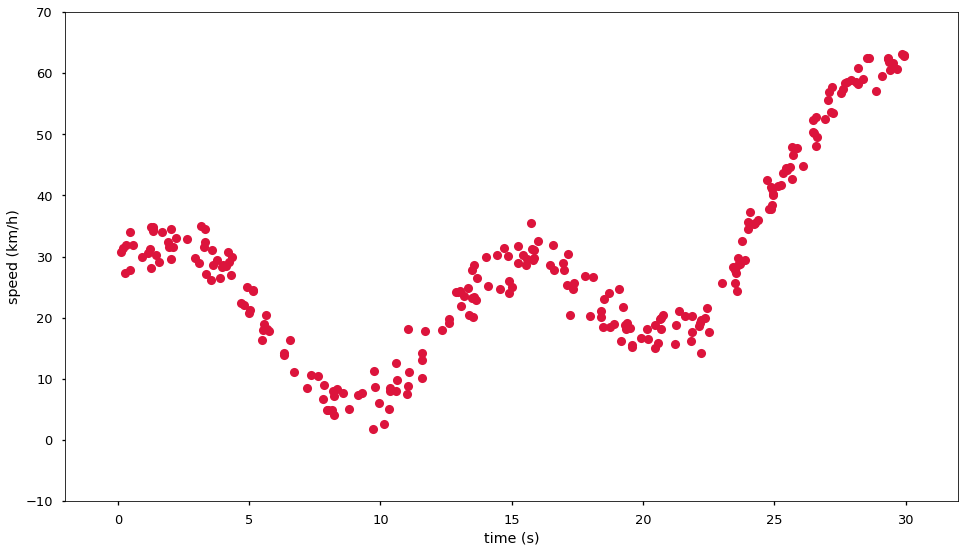

In [2]:
t = 30*np.random.rand(256)
spd = 13*np.sin(t/2) + 3.7*np.cos(t/2+7) + 3*t + 0.1*(t-10)**2 - 3*(t-3) + 7 + 2.3*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(t, spd, 'o', color='crimson')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70));

Experience tells me that for the problem at hand Lasso is the type
of regularization that will best work on our problem of heavily related inputs.
Ridge tends to reduce all weights similarly,
whilst Lasso's effect often reduces several weights to zero
and keeps reasonably high values for other weights.
The rule of thumb is to:

- If you know that you have the correct number of inputs into the problem,
  e.g. you know from some theoretical background what kind of function fit
  you are looking for, then Ridge should be the first choice.

- On the other hand, if you believe that the majority of inputs into the problem
  need to be culled then Lasso is the first choice.

- For things in between ElasticNet provides full flexibility.

For the full road trip problem the choice of regularization does not have
a big impact, we encourage you to try out different regularization methods.
Below we use a model that we well know to heavily overfit - too much model variance.
We use a big value of $\alpha$ to attempt to cull the extraneous model variance.
We add `tol=0.01` as one possibility of model convergence: if the error between
two optimizer iterations is smaller than $0.01$ then we consider that the model
has reached a good solution.
But since it is a problem we know to heavily overfit we also add
`max_iter=300000` in order for it to not run too long.
We may see a convergence warning if the model reaches that many optimizer iterations
without reaching the desired tolerance but even then the model is likely
to have reached a much better solution than without regularization.

/home/grochmal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4087.1553925199155, tolerance: 554.3004659963893
  positive)


(Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=100, include_bias=True,
                                     interaction_only=False, order='C')),
                 ('lasso',
                  Lasso(alpha=10.0, copy_X=True, fit_intercept=True,
                        max_iter=300000, normalize=False, positive=False,
                        precompute=False, random_state=None, selection='cyclic',
                        tol=0.01, warm_start=False))],
          verbose=False),
 array([32.01397707]),
 array([ 0.00000000e+000, -0.00000000e+000, -7.43980210e-001,
         4.73707841e-002,  2.90051407e-003, -1.80952082e-004,
        -2.35217454e-006,  3.69875155e-008,  2.71912033e-009,
         8.40868532e-011,  1.76772664e-012,  2.05682938e-014,
        -3.43356351e-016, -3.35647026e-017, -1.47336182e-018,
        -5.09908205e-020, -1.53818196e-021, -4.15768103e-023,
        -1.00062166e-024, -2.03586817e-026, -2.81179269e-028,
      

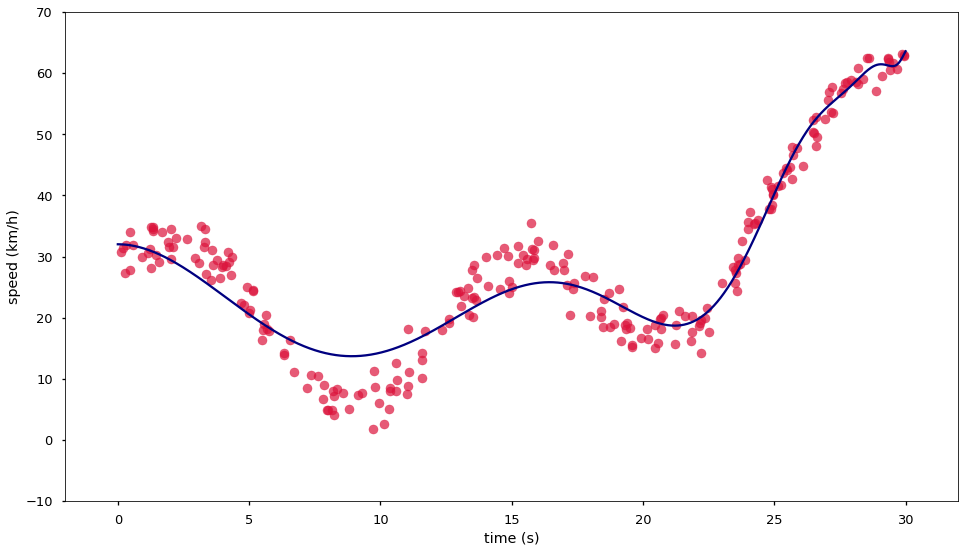

In [3]:
model = make_pipeline(PolynomialFeatures(degree=100), Lasso(alpha=10.0, tol=0.01, max_iter=300000))
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
model, model.named_steps.lasso.intercept_, model.named_steps.lasso.coef_

Despite the fact that we know that a polynomial of degree 100 heavily *overfits* the data,
and, moreover, its parameters start to influence each other, we still managed to find a good fit.
This is because, thanks to the regularization, the parameters that were heavily dependent
on each other were forced to be very close to zero.
Also note how the majority of the weights are tiny numbers very close to zero,
only a few weights are effectively used during model prediction.

This is good but likely this is still not the best solution we can achieve.
Now we got another *hyperparameter* to tune: the *alpha* of the regularization.

## Model Selection - Again

We did this before but now we have two hyperparameters to tune:
polynomial *degree* and ridge *alpha*.
The grid search uses a double underscore (`__`) to indicate a hyperparameter
(argument to model constructor).
In a pipeline the - all lowercase - name of the model, followed by the double
underscore, followed by the hyperparameter values to try;
performs the training and cross-validation across *all combinations* in the grid.

since we will be training lots of models we reduce the number of
`max_iter=` to a sensible value that will not make us wait hours for the cell to complete.
Most of these models will *not* converge to a solution but the cross validation
will just consider them to be bad models and discard them.
In order to not fill our screen with warnings we ask Python
to ignore convergence warnings from `sklearn` and matrix
transformation warnings from the optimizer working below the hood.

And since we are performing the model selection on the number of polynomial features,
i.e. on the number of inputs into the model itself,
the use of Lasso regularization makes less sense.
Lasso would attempt to reduce several input to zero but the model
selection would attempt to achieve the same.
Instead we will use Ridge regularization for our model.
It is likely that we can build in an even better model
with the correct weighing of Lasso and Ridge regularization in an Elastic Net
but we will stick to Ridge for simplicity.

In [4]:
import warnings
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=LinAlgWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

model = make_pipeline(PolynomialFeatures(degree=5), Ridge(alpha=1.0, tol=0.1, max_iter=3000))
grid = GridSearchCV(model,
                    {'polynomialfeatures__degree': list(range(5, 21)),
                     'ridge__alpha': [0.1, 0.5, 1, 2, 3, 5, 10, 20, 50, 100, 200, 300, 500]},
                    cv=5)
grid.fit(t[:, np.newaxis], spd[:, np.newaxis])
grid.best_estimator_, grid.best_score_

(Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=10, include_bias=True,
                                     interaction_only=False, order='C')),
                 ('ridge',
                  Ridge(alpha=200, copy_X=True, fit_intercept=True,
                        max_iter=3000, normalize=False, random_state=None,
                        solver='auto', tol=0.1))],
          verbose=False),
 0.9702170094318356)

And we have a quite good estimator.
Let's see how it plots over the data.

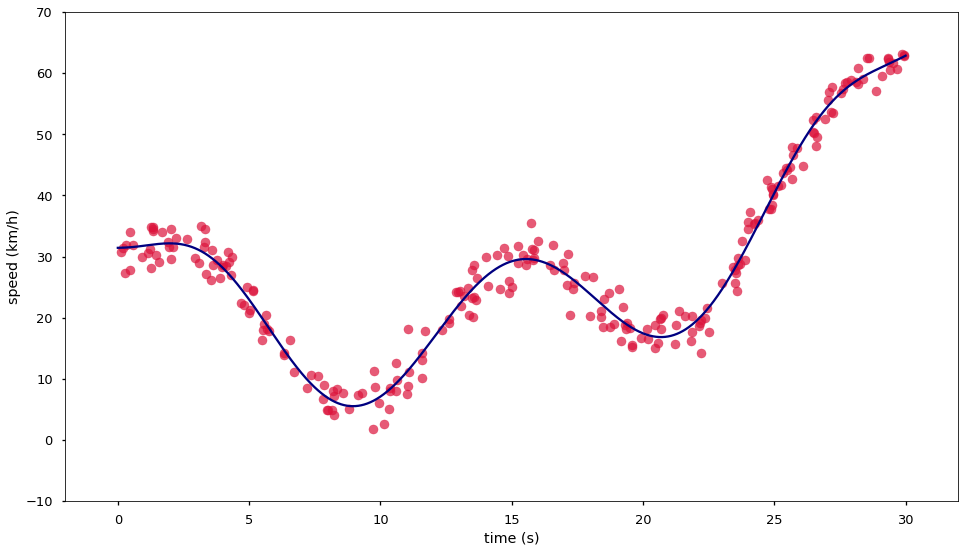

In [5]:
xfit = np.linspace(0, 30, 3000)
yfit = grid.best_estimator_.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70));

## Take home message - Generalization

We managed to estimate a quite complex function.  But most importantly, we learned that we
have an arsenal of machine learning automation in `sklearn`, cross-validation and grid-search
are common to almost every machine learning problem, no matter the model used.

Also, we saw a model that *underfits* - has high *bias* - and a model that *overfits* - has high *variance*.
This is not to be confused with high variance in the data.
Models with either too high bias or variance will **generalize** poorly.
In other words, when we perform model selection we are searching for the model that best *generalizes*.
And we can only say that a model generalizes well to new data if we can prove that
the model does not underfit or overfit the data independently on how we test it.

Note: Just because we got the model that best generalizes across a huge grid of hyperparameters
and across a vast cross-validation, it does not mean we have the best model that we can get.
We have the model that can best generalize under the assumptions we make when building it.
For example, trying a specific ML technique is an assumption about the data.
Comparing different ML techniques on the same data means comparing the best model
(the one that best generalizes) built with each technique on this data.

## References

- [Common Pitfalls in Interpretation of Linear Models - SciKit Learn Documentation][1]

[1]: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html "Common Pitfalls"